## YOLO Model

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="brain-tumor.yaml", epochs=100, imgsz=640)


TESTING DIFFERENT CONFIDENCE THRESHOLDS

--- Confidence Threshold: 0.1 ---
Reading images from: ml_project_data/brain-tumor/valid/images
Reading labels from: ml_project_data/brain-tumor/valid/labels

Processing 223 images...
  Image 1: val_1 (1) | True: 1 | Pred: 1 | Conf: 0.703
  Image 2: val_1 (10) | True: 0 | Pred: 0 | Conf: 0.923
  Image 3: val_1 (100) | True: 1 | Pred: 1 | Conf: 0.559
  Image 4: val_1 (101) | True: 0 | Pred: 1 | Conf: 0.462
  Image 5: val_1 (102) | True: 1 | Pred: 1 | Conf: 0.412
Accuracy: 0.4619 (46.19%)
TN: 38, FP: 104, FN: 16, TP: 65

--- Confidence Threshold: 0.25 ---
Reading images from: ml_project_data/brain-tumor/valid/images
Reading labels from: ml_project_data/brain-tumor/valid/labels

Processing 223 images...
  Image 1: val_1 (1) | True: 1 | Pred: 1 | Conf: 0.703
  Image 2: val_1 (10) | True: 0 | Pred: 0 | Conf: 0.923
  Image 3: val_1 (100) | True: 1 | Pred: 1 | Conf: 0.559
  Image 4: val_1 (101) | True: 0 | Pred: 1 | Conf: 0.462
  Image 5: val_1 (102) 

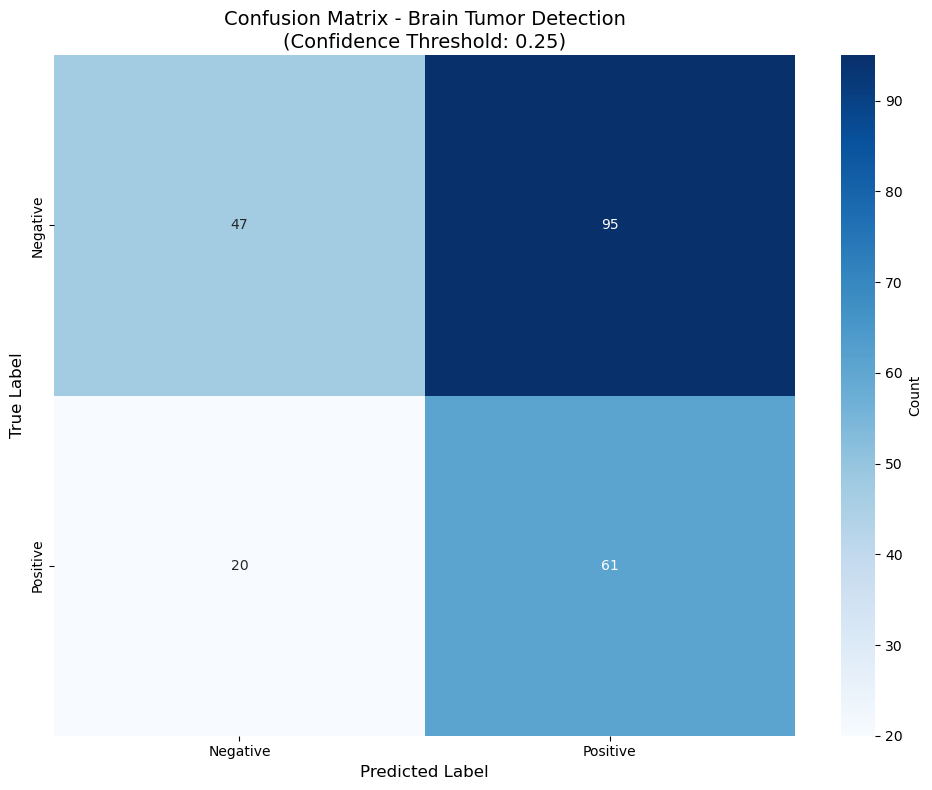


CONFUSION MATRIX BREAKDOWN
True Negatives (TN):  47 - Correctly identified as healthy
False Positives (FP): 95 - Healthy but predicted as tumor
False Negatives (FN): 20 - Tumor but predicted as healthy
True Positives (TP):  61 - Correctly identified as tumor

CLINICAL METRICS
Sensitivity (Recall):      0.7531 (75.31%) - Catches 75.3% of tumors
Specificity:               0.3310 (33.10%) - Correctly identifies 33.1% of healthy cases
Positive Predictive Value: 0.3910 (39.10%) - When it says tumor, it's right 39.1% of time
Negative Predictive Value: 0.7015 (70.15%) - When it says healthy, it's right 70.1% of time


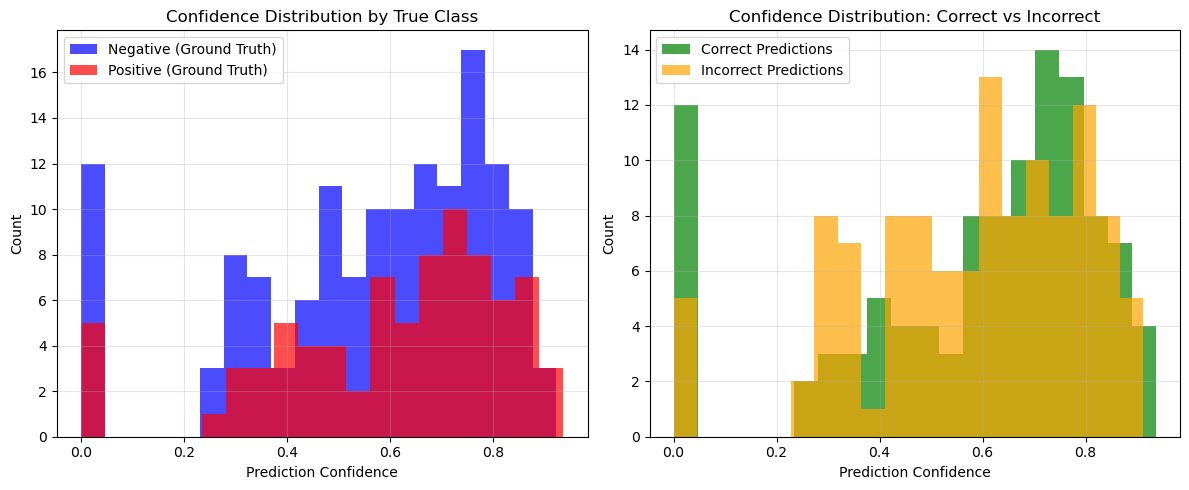


✓ Plots saved: confusion_matrix.png, confidence_distribution.png


In [16]:
from ultralytics import YOLO
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Load your trained model
model = YOLO("best.pt")

def get_ground_truth_from_labels(label_path):
    """
    Read YOLO format label file to get ground truth
    YOLO format: class_id x_center y_center width height
    Returns: 1 if positive (tumor) exists, 0 otherwise
    """
    if not os.path.exists(label_path):
        return 0  # No label file = negative (no tumor)
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    if len(lines) == 0:
        return 0  # Empty file = negative
    
    # Check if any bounding box has class 1 (positive/tumor)
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:  # Valid YOLO format: class x y w h
            class_id = int(parts[0])
            if class_id == 1:  # positive class (tumor)
                return 1
    
    # If we only found class 0 (negative) or no valid lines
    return 0

def get_image_level_predictions(model, data_yaml, split='val', conf_threshold=0.25):
    """
    Convert bounding box detections to image-level classifications
    
    Ground Truth Logic:
    - If label file has class 1 (positive) → image is POSITIVE (has tumor)
    - If label file has only class 0 (negative) → image is NEGATIVE (no tumor)
    - If no label file → image is NEGATIVE
    
    Prediction Logic:
    - If model detects class 1 with conf > threshold → predict POSITIVE
    - Otherwise → predict NEGATIVE
    
    Args:
        conf_threshold: Minimum confidence to consider a detection valid
    Returns: true_labels, pred_labels, confidences
    """
    from ultralytics.data.utils import check_det_dataset
    
    base_path = "ml_project_data/brain-tumor"
    
    val_img_path = os.path.join(base_path, "valid", "images")
    val_label_path = os.path.join(base_path, "valid", "labels")

    print(f"Reading images from: {val_img_path}")
    print(f"Reading labels from: {val_label_path}")

    if not os.path.exists(val_img_path):
        raise FileNotFoundError(f"Image directory not found: {val_img_path}")
    if not os.path.exists(val_label_path):
        raise FileNotFoundError(f"Label directory not found: {val_label_path}")

    
    # Get predictions for validation set
    results = model.predict(val_img_path, save=False, verbose=False, conf=conf_threshold)
    
    true_labels = []
    pred_labels = []
    pred_confidences = []
    
    print(f"\nProcessing {len(results)} images...")
    
    for i, result in enumerate(results):
        img_path = result.path
        img_name = Path(img_path).stem
        label_path = os.path.join(val_label_path, f"{img_name}.txt")
        
        # Get ground truth from label file
        true_label = get_ground_truth_from_labels(label_path)
        
        # Get predicted label based on detections
        if len(result.boxes) > 0:
            classes = result.boxes.cls.cpu().numpy()
            confidences = result.boxes.conf.cpu().numpy()
            
            # Check if there's any positive (class 1) detection
            positive_mask = classes == 1
            
            if np.any(positive_mask):
                # Positive detection found
                pred_label = 1
                pred_conf = np.max(confidences[positive_mask])
            else:
                # Only negative (class 0) detections
                pred_label = 0
                pred_conf = np.max(confidences) if len(confidences) > 0 else 0.0
        else:
            # No detection at all = negative
            pred_label = 0
            pred_conf = 0.0
        
        true_labels.append(true_label)
        pred_labels.append(pred_label)
        pred_confidences.append(pred_conf)
        
        # Debug first few images
        if i < 5:
            print(f"  Image {i+1}: {img_name} | True: {true_label} | Pred: {pred_label} | Conf: {pred_conf:.3f}")
    
    return np.array(true_labels), np.array(pred_labels), np.array(pred_confidences)

# Try different confidence thresholds
print("\n" + "="*70)
print("TESTING DIFFERENT CONFIDENCE THRESHOLDS")
print("="*70)

for conf_thresh in [0.1, 0.25, 0.5, 0.7]:
    print(f"\n--- Confidence Threshold: {conf_thresh} ---")
    y_true, y_pred, y_conf = get_image_level_predictions(
        model, "ml_project_data/brain-tumor.yaml", conf_threshold=conf_thresh
    )
    
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")

# Use optimal threshold
print("\n" + "="*70)
print("DETAILED METRICS (Confidence Threshold: 0.25)")
print("="*70)

y_true, y_pred, y_conf = get_image_level_predictions(model, "ml_project_data/brain-tumor.yaml", conf_threshold=0.25)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nTotal images: {len(y_true)}")
print(f"Actual Negative: {np.sum(y_true == 0)}")
print(f"Actual Positive: {np.sum(y_true == 1)}")
print(f"Predicted Negative: {np.sum(y_pred == 0)}")
print(f"Predicted Positive: {np.sum(y_pred == 1)}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=['Negative', 'Positive'],
                          digits=4))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Brain Tumor Detection\n(Confidence Threshold: 0.25)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("CONFUSION MATRIX BREAKDOWN")
print("="*70)
print(f"True Negatives (TN):  {cm[0,0]} - Correctly identified as healthy")
print(f"False Positives (FP): {cm[0,1]} - Healthy but predicted as tumor")
print(f"False Negatives (FN): {cm[1,0]} - Tumor but predicted as healthy")
print(f"True Positives (TP):  {cm[1,1]} - Correctly identified as tumor")

# Calculate additional metrics
if (cm[1,1] + cm[1,0]) > 0:
    sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
else:
    sensitivity = 0

if (cm[0,0] + cm[0,1]) > 0:
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
else:
    specificity = 0

if (cm[1,1] + cm[0,1]) > 0:
    ppv = cm[1,1] / (cm[1,1] + cm[0,1])
else:
    ppv = 0

if (cm[0,0] + cm[1,0]) > 0:
    npv = cm[0,0] / (cm[0,0] + cm[1,0])
else:
    npv = 0

print("\n" + "="*70)
print("CLINICAL METRICS")
print("="*70)
print(f"Sensitivity (Recall):      {sensitivity:.4f} ({sensitivity*100:.2f}%) - Catches {sensitivity*100:.1f}% of tumors")
print(f"Specificity:               {specificity:.4f} ({specificity*100:.2f}%) - Correctly identifies {specificity*100:.1f}% of healthy cases")
print(f"Positive Predictive Value: {ppv:.4f} ({ppv*100:.2f}%) - When it says tumor, it's right {ppv*100:.1f}% of time")
print(f"Negative Predictive Value: {npv:.4f} ({npv*100:.2f}%) - When it says healthy, it's right {npv*100:.1f}% of time")

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_conf[y_true == 0], bins=20, alpha=0.7, label='Negative (Ground Truth)', color='blue')
plt.hist(y_conf[y_true == 1], bins=20, alpha=0.7, label='Positive (Ground Truth)', color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution by True Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
correct = y_true == y_pred
plt.hist(y_conf[correct], bins=20, alpha=0.7, label='Correct Predictions', color='green')
plt.hist(y_conf[~correct], bins=20, alpha=0.7, label='Incorrect Predictions', color='orange')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution: Correct vs Incorrect')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plots saved: confusion_matrix.png, confidence_distribution.png")